#### For classification algorithms, one of the most common usage patterns is thresholding:

Thresholding is popular because of its simplicity and ease of implementation: We translate a continuous score to a binary yes/no decision, and act on it in a predetermined way.

### Where should I set the threshold point?

#### There are three factors to consider when choosing a threshold point:

Queue Rate: How many cases do you want to act on? This will depend on the cost of treating an individual case, as well as your overall capacity. If you're asking a team of reviewers to look at potential fake accounts, then the number of cases you can flag is limited by the resources of that team: How many cases do they have the ability to review within your timeframe? If, on the other hand, you're sending out mass emails, your variable cost is nearly zero, and you can afford to queue a lot of cases. Etc.

Precision: What's the downside when you erroneously queue a case? If you're reviewing fraudulent accounts, the cost is wasted reviewer time. If you mistakenly send a 10% off coupon to someone who would have completed his or her purchase anyway, your cost is 10% of their shopping cart. Etc.

Recall: What's the downside when you fail to queue a case that should have been queued? If you're queueing sales leads, you're losing the value of a missed opportunity. If you're reviewing fake accounts, the cost is tied to the cost of having fraudulent accounts in your network. Etc.

In [14]:
# Imports
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cross_validation import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import precision_recall_curve  
from sklearn.preprocessing import LabelEncoder


In [2]:
# Retrieve Data Set
df = pd.read_csv('http://www.dataminingconsultant.com/data/churn.txt')


In [3]:
df.head(2)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [4]:
# Some Prepreocessing for changing
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

In [6]:
state_encoder = LabelEncoder()  
df.state = state_encoder.fit_transform(df.state)

del df['phone']

In [7]:
binary_columns = ['intl_plan', 'vmail_plan', 'churn']  
for col in binary_columns:  
    df[col] = df[col].map({
            'no': 0
        ,   'False.': 0
        ,   'yes': 1
        ,   'True.': 1
    })

In [8]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [9]:
# Build the classifier and get the predictions
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)  
clf.fit(train_signals, train_labels)  
predictions = clf.predict_proba(test_signals)[:,1] 

### Now let's see what the performance of this model is as a function of the threshold.

#### precision_recall_curve function

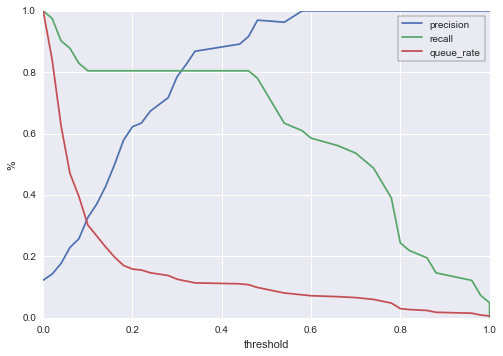

In [15]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
thresholds = np.append(thresholds, 1)

queue_rate = []  
for threshold in thresholds:  
    queue_rate.append((predictions >= threshold).mean())

plt.plot(thresholds, precision, color=sns.color_palette()[0])  
plt.plot(thresholds, recall, color=sns.color_palette()[1])  
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

Here's how we can read this chart: For a given threshold on the x-axis, we can see queue rate, precision, and recall expressed as percentages against the y-axis. 

For example, if we choose a threshold of 0.4 (all cases with a score above 0.4 get reviewed / sent an offer / whatever treatment we have at hand), then:


    About 14% of cases will be queued. So if 10k accounts are scored for churn each day, about 1400 of them will be selected for special treatment.

    Our precision will be about 92%. So of the cases we queue, 92% will really go on to churn if we don't intervene.

    Our recall will be about 80%. Of all users who will churn before the next billing period, we'll catch 80% with our model.

## Dealing with Model Variability

 It's better to visualize many train/test splits to get an idea of the range of possible performance outcomes. One of the simplest ways to do this is to perform many random train/test splits, and plot the curves for each. Here's what that looks like for 50 random splits on the telecom churn model:

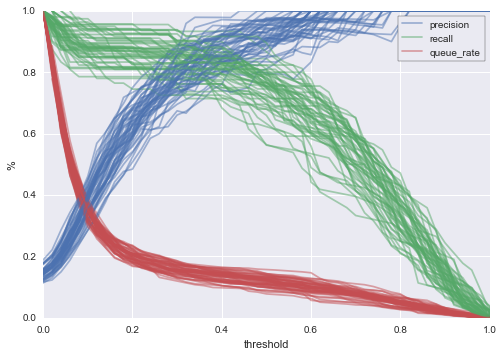

In [16]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

n_trials = 50  
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

plot_data = []

for trial in range(n_trials):  
    train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]

    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
    thresholds = np.append(thresholds, 1)

    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())

    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })

for p in plot_data:  
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

Looking at the new chart, which shows 50 train/test splits, we might now say instead that a threshold of 0.4 would produce:

A queue rate of between 10% and 20%

Precision of between 70% and 100%

Recall of between 60% and 90%.

### We can make more precise statements with a statistical visualization.

Let's plot the median curves, along with a 90% central interval for each threshold:

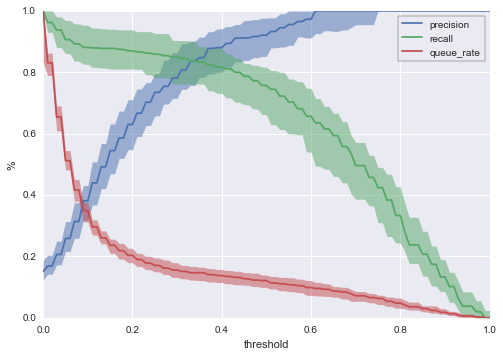

In [18]:
import bisect  
from scipy.stats import mstats

uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []

for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%') 

Now we can be considerably more precise by saying that for a threshold of 0.4, we expect:

A 90% chance that our queue rate will be between ~11% and ~15%, with median value ~13%.

A 90% chance that our precision will be between ~80% and ~95%, with median value ~90%.

A 90% chance that our recall will be between ~70% and ~85% with a median value ~80%.

This gives you the opportunity to move beyond the technical role of building a model into the role of deciding what to actually do with your model. All you need to get started is the chart above and some back of the envelope numbers for cost/benefit analysis.

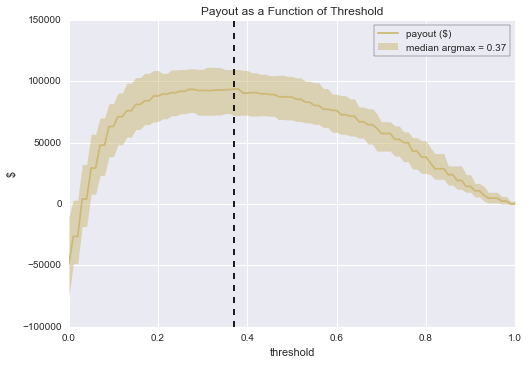

In [19]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]

        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]  
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold") 

In general, using the queue rate / precision / recall graph is an easy way to perform "what if" analysis on the operational and strategic decision of how your model can be best used.

In [20]:
sns.set_style('darkgrid')

In [21]:
names = [
       'mpg'
    ,  'cylinders'
    ,  'displacement'
    ,  'horsepower'
    ,  'weight'
    ,  'acceleration'
    ,  'model_year'
    ,  'origin'
    ,  'car_name'
]
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", sep='\s+', names=names)
df['maker'] = df.car_name.map(lambda x: x.split()[0])
df.origin = df.origin.map({1: 'America', 2: 'Europe', 3: 'Asia'})
df=df.applymap(lambda x: np.nan if x == '?' else x).dropna()
df['horsepower'] = df.horsepower.astype(float)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,maker
0,18.0,8,307.0,130.0,3504.0,12.0,70,America,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693.0,11.5,70,America,buick skylark 320,buick
2,18.0,8,318.0,150.0,3436.0,11.0,70,America,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,America,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,America,ford torino,ford


One of the most powerful features of Seaborn is the ability to easily build conditional plots; this let's us see what the data look like when segmented by one or more variables. The easiest way to do this is thorugh factorplot. 

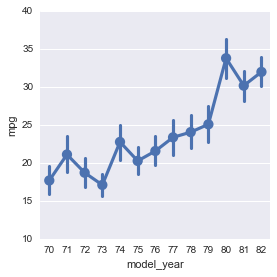

In [22]:
sns.factorplot(data=df, x="model_year", y="mpg") 

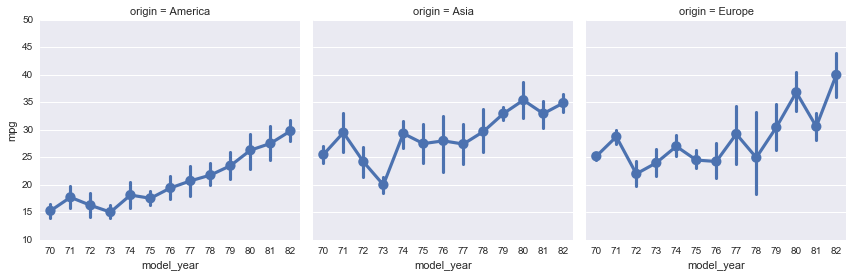

In [23]:
sns.factorplot(data=df, x="model_year", y="mpg", col="origin")  

What's so great factorplot is that rather than having to segment the data ourselves and make the conditional plots individually, Seaborn provides a convenient API for doing it all at once.

#### The FacetGrid object is a slightly more complex, but also more powerful, take on the same idea.

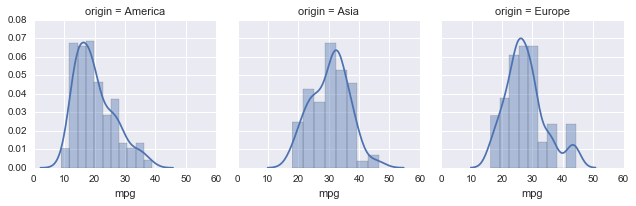

In [24]:
g = sns.FacetGrid(df, col="origin")  
g.map(sns.distplot, "mpg")  

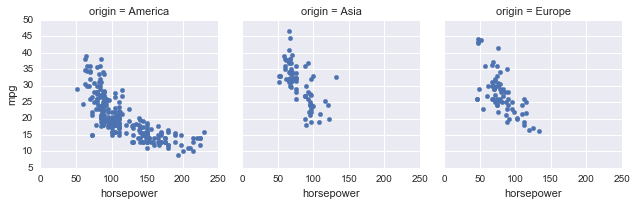

In [25]:
g = sns.FacetGrid(df, col="origin")  
g.map(plt.scatter, "horsepower", "mpg") 

#### Using FacetGrid, we can map any plotting function onto each segment of our data. 

(0, 60)

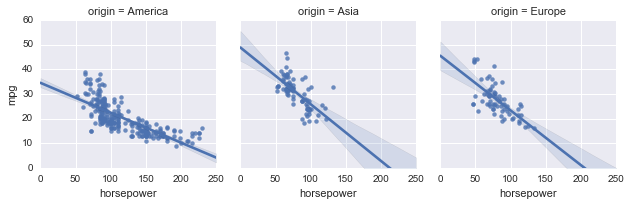

In [26]:
g = sns.FacetGrid(df, col="origin")  
g.map(sns.regplot, "horsepower", "mpg")  
plt.xlim(0, 250)  
plt.ylim(0, 60) 

We can even segment by multiple variables at once, spreading some along the rows and some along the columns. This is very useful for producing comparing conditional distributions across interacting segmentations:

(0, 60)

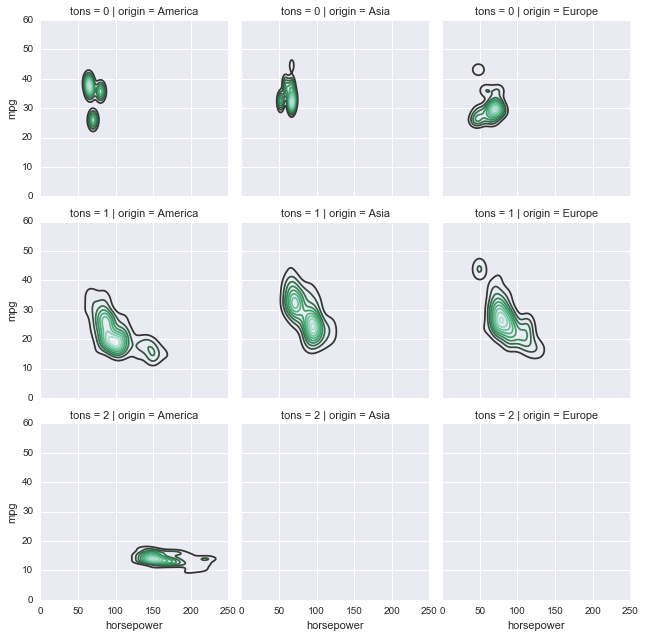

In [27]:
df['tons'] = (df.weight/2000).astype(int)  
g = sns.FacetGrid(df, col="origin", row="tons")  
g.map(sns.kdeplot, "horsepower", "mpg")  
plt.xlim(0, 250)  
plt.ylim(0, 60)  

##### While factorplot and FacetGrid are for drawing conditional plots of segmented data, pairplot and PairGrid are for showing the interactions between variables

For our car data set, we know that MPG, horsepower, and weight are probably going to be related; we also know that both these variable values and their relationships with one another, might vary by country of origin.

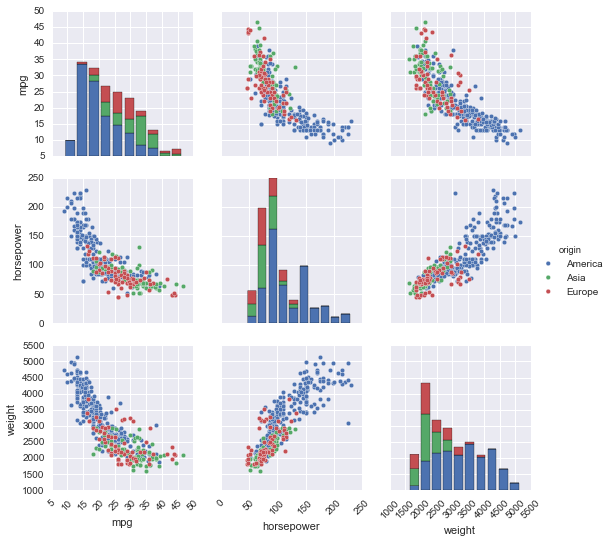

In [28]:
g = sns.pairplot(df[["mpg", "horsepower", "weight", "origin"]], hue="origin", diag_kind="hist")  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

###### PairGrid gives a bit more freedom on the same idea as pairplot by letting you control the individual plot types separately. 

Let's say, for example, that we're building regression plots, and we'd like to see both the original data and the residuals at once.

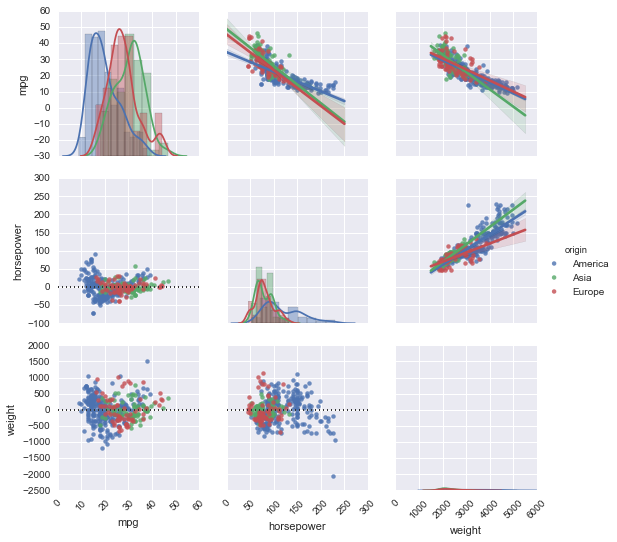

In [36]:
g = sns.PairGrid(df[["mpg", "horsepower", "weight", "origin"]], hue="origin")  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(sns.distplot)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.add_legend()  
g.set(alpha=0.5)  

We were able to control three regions (the diagonal, the lower-left triangle, and the upper-right triangle) separately.

###### jointplot and JointGrid let you easily view both a joint distribution and its marginals at once. Let's say, for example, that aside from being interested in how MPG and horsepower are distributed individually, we're also interested in their joint distribution:

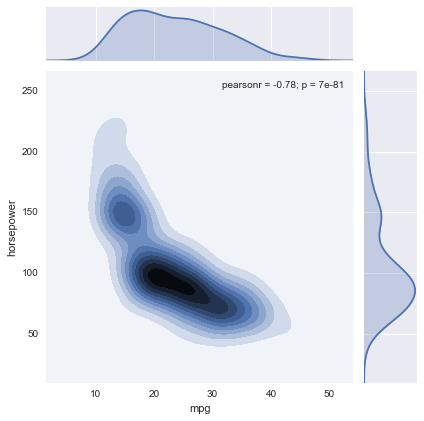

In [37]:
sns.jointplot("mpg", "horsepower", data=df, kind='kde')

JointGrid gives you a bit more control by letting you map the marginal and joint data separately. 

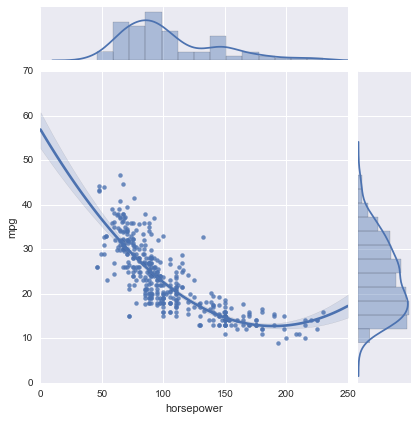

In [38]:
g = sns.JointGrid(x="horsepower", y="mpg", data=df)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  